In [1]:
!pip install rasterio
!pip install tensorflow
!pip install xarray


# STEP 1: Install dependencies
!pip install pandas openpyxl matplotlib scikit-learn pytz pvlib

# STEP 2: Import libraries
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import imageio
import pytz
import random
import os

import rasterio
from rasterio.windows import Window

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (ConvLSTM2D, Conv3D, Dense, Flatten, Dropout, BatchNormalization,
                               Input, Conv2D, Conv2DTranspose, Reshape)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


from datetime import datetime
from datetime import timedelta

import pvlib
from pvlib.location import Location

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 40.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.3/19.3 MB 80.3 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# Load & Extract INSAT Data
input_directory = "/content/drive/MyDrive/solar_project/2019_Data/"
output_directory = "/content/drive/MyDrive/solar_project/p1"


def load_insat_data(hdf5_file, dataset_name):
    with h5py.File(hdf5_file, 'r') as f:
        if dataset_name not in f:
            return None
        return f[dataset_name][:]

def process_hdf5(file_path, dataset_name):
    data = load_insat_data(file_path, dataset_name)
    return data if data is not None else None

if not os.path.exists(output_directory):
    os.makedirs(output_directory)

h5_files = [f for f in os.listdir(input_directory) if f.endswith(".h5")]

dataset_name = "IMG_VIS"  # Adjust based on the INSAT product

for filename in h5_files:
    file_path = os.path.join(input_directory, filename)
    processed_data = process_hdf5(file_path, dataset_name)
    if processed_data is not None:
        output_file = os.path.join(output_directory, filename.replace(".h5", ".npy"))
        np.save(output_file, processed_data)
        print(f"Saved processed data to {output_file}")
    else:
        print(f"Failed to process {filename}")

Saved processed data to /content/drive/MyDrive/solar_project/p1/3DIMG_03SEP2019_1100_L1C_ASIA_MER_B1.npy
Saved processed data to /content/drive/MyDrive/solar_project/p1/3DIMG_03SEP2019_1000_L1C_ASIA_MER_B1.npy
Saved processed data to /content/drive/MyDrive/solar_project/p1/3DIMG_03SEP2019_0930_L1C_ASIA_MER_B1.npy
Saved processed data to /content/drive/MyDrive/solar_project/p1/3DIMG_03SEP2019_1130_L1C_ASIA_MER_B1.npy
Saved processed data to /content/drive/MyDrive/solar_project/p1/3DIMG_03SEP2019_0530_L1C_ASIA_MER_B1.npy
Saved processed data to /content/drive/MyDrive/solar_project/p1/3DIMG_03SEP2019_0900_L1C_ASIA_MER_B1.npy
Saved processed data to /content/drive/MyDrive/solar_project/p1/3DIMG_03SEP2019_0400_L1C_ASIA_MER_B1.npy
Saved processed data to /content/drive/MyDrive/solar_project/p1/3DIMG_03SEP2019_1030_L1C_ASIA_MER_B1.npy
Saved processed data to /content/drive/MyDrive/solar_project/p1/3DIMG_03SEP2019_0730_L1C_ASIA_MER_B1.npy
Saved processed data to /content/drive/MyDrive/solar_pr

In [ ]:
Clipped_directory = "/content/drive/MyDrive/solar_project/p1_clipped"
if not os.path.exists(Clipped_directory):
    os.makedirs(Clipped_directory)
# Clip Satellite Images for a Specific Location (lat, lon)
def extract_insat_region(insat_data, lat, lon, bbox_size=(150, 150)):
    # Convert lat/lon to pixel index (INSAT has different projections, need georeferencing)
    # Adjust conversion factors to ensure pixel indices are within data bounds.
    # Original approximate conversion might be out of bounds.
    height, width = insat_data.shape[1:]  # Get height and width from insat_data shape
    row = int(lat * height / 360)  # Assume latitude ranges from -90 to +90
    col = int(lon * width / 360)  # Assume longitude ranges from -180 to +180

    # Ensure window is within data bounds
    row_start = max(0, row - bbox_size[0] // 2)
    row_end = min(height, row + bbox_size[0] // 2)
    col_start = max(0, col - bbox_size[1] // 2)
    col_end = min(width, col + bbox_size[1] // 2)

    window = (slice(row_start, row_end), slice(col_start, col_end))
    #region_data = insat_data[0, window[0], window[1]]  # Access data using the corrected window
    # The issue was that you were only taking a single slice from the first index of insat_data
    # Assuming you want a time series, you need to extract along the first dimension
    region_data = insat_data[:, window[0], window[1]] # Updated: Selecting all elements along the first dimension


    # Check if region_data is empty
    if region_data.size == 0:
        raise ValueError("Extracted region is empty. Check latitude and longitude values or bbox_size.")

    return (region_data - np.min(region_data)) / (np.max(region_data) - np.min(region_data))  # Normalize

# Define Coordinates
lat, lon = 13.627, 79.397
npy_files = [f for f in os.listdir(output_directory) if f.endswith(".npy")]
for npy_file in npy_files:
    npy_path = os.path.join(output_directory, npy_file)
    insat_data = np.load(npy_path)
    clipped_insat_images = extract_insat_region(insat_data, lat, lon)
    num_frames, height, width = clipped_insat_images.shape
    clipped_insat_images = clipped_insat_images.reshape((num_frames, height, width, 1))
    output_file = os.path.join(Clipped_directory, npy_file)
    np.save(output_file, clipped_insat_images)
    print(f"Saved clipped images to {output_file}")


Saved clipped images to /content/drive/MyDrive/solar_project/p1_clipped/3DIMG_01SEP2019_1030_L1C_ASIA_MER_B1.npy
Saved clipped images to /content/drive/MyDrive/solar_project/p1_clipped/3DIMG_01SEP2019_1000_L1C_ASIA_MER_B1.npy
Saved clipped images to /content/drive/MyDrive/solar_project/p1_clipped/3DIMG_01SEP2019_0830_L1C_ASIA_MER_B1.npy
Saved clipped images to /content/drive/MyDrive/solar_project/p1_clipped/3DIMG_01SEP2019_0600_L1C_ASIA_MER_B1.npy
Saved clipped images to /content/drive/MyDrive/solar_project/p1_clipped/3DIMG_01SEP2019_0730_L1C_ASIA_MER_B1.npy
Saved clipped images to /content/drive/MyDrive/solar_project/p1_clipped/3DIMG_01SEP2019_0430_L1C_ASIA_MER_B1.npy
Saved clipped images to /content/drive/MyDrive/solar_project/p1_clipped/3DIMG_01SEP2019_0400_L1C_ASIA_MER_B1.npy
Saved clipped images to /content/drive/MyDrive/solar_project/p1_clipped/3DIMG_01SEP2019_0500_L1C_ASIA_MER_B1.npy
Saved clipped images to /content/drive/MyDrive/solar_project/p1_clipped/3DIMG_01SEP2019_1100_L1C

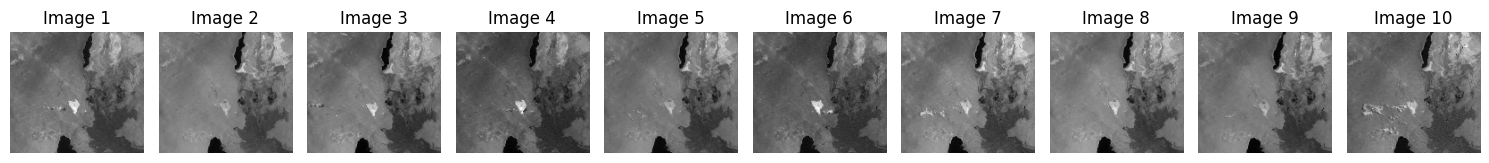

In [ ]:
input_directory = "/content/drive/MyDrive/solar_project/p1_clipped"

# Load all .npy files and stack them
npy_files = [f for f in os.listdir(input_directory) if f.endswith(".npy")]
image_stack = []

for npy_file in npy_files:
    npy_path = os.path.join(input_directory, npy_file)
    images = np.load(npy_path)

    # Ensure 3D or 4D input (frames, height, width) or (height, width)
    if images.ndim == 2:
        images = np.expand_dims(images, axis=0)

    for img in images:
        # Normalize image and ensure correct shape
        img = img.astype('float32') / 255.0
        img = np.expand_dims(img, axis=-1)  # Add channel dimension
        image_stack.append(img)

# Now plot a few images from image_stack
num_images_to_plot = min(10, len(image_stack))  # limit to 10 images or fewer
plt.figure(figsize=(15, 5))

for i in range(num_images_to_plot):
    plt.subplot(1, num_images_to_plot, i + 1)
    plt.imshow(image_stack[i].squeeze(), cmap='gray')
    plt.axis('off')
    plt.title(f'Image {i+1}')

plt.tight_layout()
plt.show()


Data shape: (611, 136, 150, 1)
Epoch 1/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 91s 13s/step - loss: 0.0404 - val_loss: 0.0272
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 141s 12s/step - loss: 0.0264 - val_loss: 0.0287
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 144s 13s/step - loss: 0.0250 - val_loss: 0.0241
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 138s 12s/step - loss: 0.0220 - val_loss: 0.0208
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 142s 12s/step - loss: 0.0188 - val_loss: 0.0175
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 147s 13s/step - loss: 0.0158 - val_loss: 0.0171
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 136s 12s/step - loss: 0.0151 - val_loss: 0.0154
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 147s 13s/step - loss: 0.0141 - val_loss: 0.0148
Epoch 9/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 142s 13s/step - loss: 0.0128 - val_loss: 0.0142
Epoch 10/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 102s 15s/step - loss: 0.0126 - val_loss: 0.0126
Epoch 11/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 127s 12s/step - loss: 0.0120 - val_loss: 0.0123
Epoch 12/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 145s 13

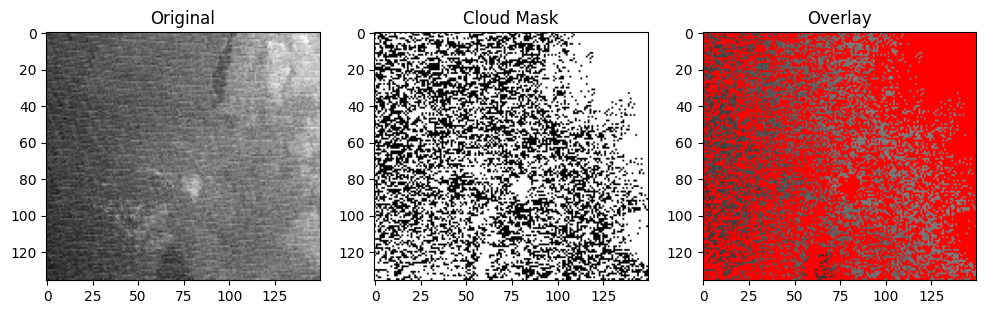

Saved mask: /content/drive/MyDrive/solar_project/cloud_masks/cloudmask_3DIMG_01SEP2019_0130_L1C_ASIA_MER_B1.npy


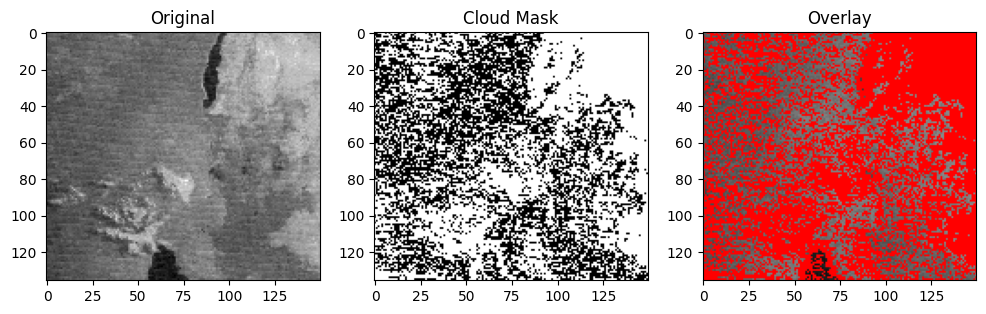

Saved mask: /content/drive/MyDrive/solar_project/cloud_masks/cloudmask_3DIMG_01SEP2019_0200_L1C_ASIA_MER_B1.npy


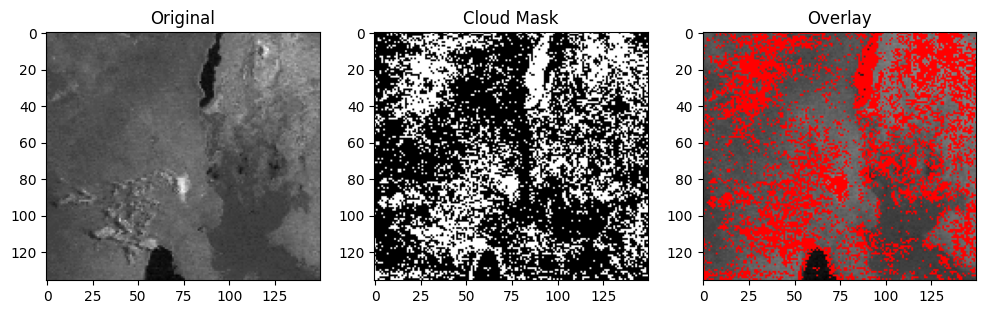

Saved mask: /content/drive/MyDrive/solar_project/cloud_masks/cloudmask_3DIMG_01SEP2019_0230_L1C_ASIA_MER_B1.npy
Saved mask: /content/drive/MyDrive/solar_project/cloud_masks/cloudmask_3DIMG_01SEP2019_0300_L1C_ASIA_MER_B1.npy
Saved mask: /content/drive/MyDrive/solar_project/cloud_masks/cloudmask_3DIMG_01SEP2019_0330_L1C_ASIA_MER_B1.npy
Saved mask: /content/drive/MyDrive/solar_project/cloud_masks/cloudmask_3DIMG_01SEP2019_0400_L1C_ASIA_MER_B1.npy
Saved mask: /content/drive/MyDrive/solar_project/cloud_masks/cloudmask_3DIMG_01SEP2019_0430_L1C_ASIA_MER_B1.npy
Saved mask: /content/drive/MyDrive/solar_project/cloud_masks/cloudmask_3DIMG_01SEP2019_0500_L1C_ASIA_MER_B1.npy
Saved mask: /content/drive/MyDrive/solar_project/cloud_masks/cloudmask_3DIMG_01SEP2019_0530_L1C_ASIA_MER_B1.npy
Saved mask: /content/drive/MyDrive/solar_project/cloud_masks/cloudmask_3DIMG_01SEP2019_0600_L1C_ASIA_MER_B1.npy
Saved mask: /content/drive/MyDrive/solar_project/cloud_masks/cloudmask_3DIMG_01SEP2019_0630_L1C_ASIA_MER

In [ ]:
data_dir = "/content/drive/MyDrive/solar_project/p1_clipped"
mask_output_dir = "/content/drive/MyDrive/solar_project/cloud_masks"
os.makedirs(mask_output_dir, exist_ok=True)

image_files = sorted([f for f in os.listdir(data_dir) if f.endswith(".npy")])
X = np.array([np.load(os.path.join(data_dir, f)) for f in image_files])  # shape: (N, H, W)

X = X.astype(np.float32)
X = (X - X.min()) / (X.max() - X.min() + 1e-6)
X = X.squeeze()  # Remove extra dimension(s)
X = X[..., np.newaxis]  # (N, H, W, 1) # Add channel dimension back

print("Data shape:", X.shape)
X_train, X_test = train_test_split(X, test_size=0.3, random_state=42)

# Parameters
latent_dim = 64
epochs = 10
batch_size = 4

def build_autoencoder(input_shape):
    inputs = Input(shape=input_shape)

    # Encoder
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    encoded = Flatten()(x)
    latent_space = Dense(latent_dim, activation='relu')(encoded)

    # Decoder
    x = Dense(input_shape[0] * input_shape[1] * 16, activation='relu')(latent_space)
    x = Reshape((input_shape[0], input_shape[1], 16))(x)
    x = Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(x)
    x = Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(x)
    decoded = Conv2DTranspose(1, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = Model(inputs, decoded)
    autoencoder.compile(optimizer=Adam(), loss='mse')
    return autoencoder


autoencoder = build_autoencoder(input_shape=X.shape[1:])  # Pass the correct input shape
autoencoder.fit(X_train, X_train, epochs=20, batch_size=50, validation_split=0.2)


def get_cloud_mask(original, reconstructed, threshold=0.08):
    error_map = np.abs(original - reconstructed)
    norm_error = (error_map - error_map.min()) / (error_map.max() - error_map.min() + 1e-6)
    mask = (norm_error > threshold).astype(np.uint8)
    return mask.squeeze(), norm_error.squeeze()

for i, img in enumerate(X):
    recon = autoencoder.predict(img[np.newaxis], verbose=0)[0]
    mask, err_map = get_cloud_mask(img, recon)

    mask_path = os.path.join(mask_output_dir, f"cloudmask_{image_files[i].replace('.npy', '')}.npy")
    np.save(mask_path, mask)

    if i < 3:
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.imshow(img.squeeze(), cmap='gray'); plt.title("Original")
        plt.subplot(1, 3, 2)
        plt.imshow(mask, cmap='gray'); plt.title("Cloud Mask")
        plt.subplot(1, 3, 3)
        overlay = np.stack([img.squeeze()] * 3, axis=-1)
        overlay[mask == 1] = [1, 0, 0]
        plt.imshow(overlay); plt.title("Overlay")
        plt.show()

    print(f"Saved mask: {mask_path}")

In [ ]:
# Create Matching GHI Labels
ghi_xls_path = "/content/drive/MyDrive/solar_project/tirupati_ground_data.xlsx"
ghi_df = pd.read_excel(ghi_xls_path)

# Convert 'timestamp' column from IST to UTC
ghi_df['Date'] = pd.to_datetime(ghi_df['Date'])  # ensure datetime format
ghi_df['Date_utc'] = ghi_df['Date'] - timedelta(hours=5, minutes=30)
# Load cloud mask filenames
mask_dir = "/content/drive/MyDrive/solar_project/cloud_masks"
mask_files = sorted([f for f in os.listdir(mask_dir) if f.endswith(".npy")])

# Extract UTC timestamps from filenames
file_timestamps = []
for fname in mask_files:
  parts = fname.split('_')  # ['cloudmask', '3DIMG', '01SEP2019', '0130', 'L1C', ...]
  date_part = parts[2]  # '01SEP2019'
  time_part = parts[3]  # '0130'
  date_str = date_part + time_part  # '01SEP20190130'

  # Convert to datetime object in UTC
  ts = datetime.strptime(date_str, "%d%b%Y%H%M")
  file_timestamps.append(ts)

# Match each cloud mask to GHI value
ghi_labels = []
for ts in file_timestamps:
    match = ghi_df[ghi_df['Date_utc'] == ts]
    if not match.empty:
        ghi_labels.append(match.iloc[0]['Ground_data'])
    else:
        ghi_labels.append(np.nan)  # handle missing values later

# Save GHI labels aligned with mask filenames
ghi_labels = np.array(ghi_labels)
np.save("/content/drive/MyDrive/solar_project/ghi_labels.npy", ghi_labels)
print("Matching GHI values saved for cloud masks.")

Matching GHI values saved for cloud masks.


Epoch 1/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step - loss: 0.2298 - mae: 0.5476

16/16 ━━━━━━━━━━━━━━━━━━━━ 19s 545ms/step - loss: 0.2256 - mae: 0.5417 - val_loss: 0.0710 - val_mae: 0.2941 - learning_rate: 0.0010
Epoch 2/150
13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0769 - mae: 0.3138

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0759 - mae: 0.3112 - val_loss: 0.0672 - val_mae: 0.2847 - learning_rate: 0.0010
Epoch 3/150
13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0623 - mae: 0.2801

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0609 - mae: 0.2772 - val_loss: 0.0653 - val_mae: 0.2801 - learning_rate: 0.0010
Epoch 4/150
14/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0481 - mae: 0.2474

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0473 - mae: 0.2449 - val_loss: 0.0640 - val_mae: 0.2772 - learning_rate: 0.0010
Epoch 5/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0417 - mae: 0.2304

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0415 - mae: 0.2297 - val_loss: 0.0625 - val_mae: 0.2736 - learning_rate: 0.0010
Epoch 6/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0324 - mae: 0.2037

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0324 - mae: 0.2035 - val_loss: 0.0599 - val_mae: 0.2674 - learning_rate: 0.0010
Epoch 7/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0295 - mae: 0.1953

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0294 - mae: 0.1949 - val_loss: 0.0561 - val_mae: 0.2586 - learning_rate: 0.0010
Epoch 8/150
11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0274 - mae: 0.1896

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0270 - mae: 0.1870 - val_loss: 0.0550 - val_mae: 0.2560 - learning_rate: 0.0010
Epoch 9/150
13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0257 - mae: 0.1796

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0255 - mae: 0.1785 - val_loss: 0.0524 - val_mae: 0.2505 - learning_rate: 0.0010
Epoch 10/150
12/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0246 - mae: 0.1774

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0243 - mae: 0.1757 - val_loss: 0.0496 - val_mae: 0.2447 - learning_rate: 0.0010
Epoch 11/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0241 - mae: 0.1739

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0240 - mae: 0.1735 - val_loss: 0.0468 - val_mae: 0.2381 - learning_rate: 0.0010
Epoch 12/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0219 - mae: 0.1647

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0219 - mae: 0.1645 - val_loss: 0.0457 - val_mae: 0.2354 - learning_rate: 0.0010
Epoch 13/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0213 - mae: 0.1621

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0213 - mae: 0.1620 - val_loss: 0.0441 - val_mae: 0.2319 - learning_rate: 0.0010
Epoch 14/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0202 - mae: 0.1568

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0201 - mae: 0.1567 - val_loss: 0.0416 - val_mae: 0.2258 - learning_rate: 0.0010
Epoch 15/150
13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0217 - mae: 0.1636

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0215 - mae: 0.1624 - val_loss: 0.0415 - val_mae: 0.2255 - learning_rate: 0.0010
Epoch 16/150
13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0199 - mae: 0.1565

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0199 - mae: 0.1563 - val_loss: 0.0388 - val_mae: 0.2194 - learning_rate: 0.0010
Epoch 17/150
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0208 - mae: 0.1591

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0207 - mae: 0.1588 - val_loss: 0.0382 - val_mae: 0.2193 - learning_rate: 0.0010
Epoch 18/150
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0186 - mae: 0.1499

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0186 - mae: 0.1496 - val_loss: 0.0380 - val_mae: 0.2195 - learning_rate: 0.0010
Epoch 19/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0185 - mae: 0.1493

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0185 - mae: 0.1493 - val_loss: 0.0368 - val_mae: 0.2164 - learning_rate: 0.0010
Epoch 20/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0196 - mae: 0.1560 - val_loss: 0.0368 - val_mae: 0.2169 - learning_rate: 0.0010
Epoch 21/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0184 - mae: 0.1502

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0184 - mae: 0.1500 - val_loss: 0.0368 - val_mae: 0.2176 - learning_rate: 0.0010
Epoch 22/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0187 - mae: 0.1513

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0187 - mae: 0.1511 - val_loss: 0.0352 - val_mae: 0.2135 - learning_rate: 0.0010
Epoch 23/150
11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0188 - mae: 0.1514

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0185 - mae: 0.1499 - val_loss: 0.0342 - val_mae: 0.2103 - learning_rate: 0.0010
Epoch 24/150
11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0180 - mae: 0.1501

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0179 - mae: 0.1489 - val_loss: 0.0336 - val_mae: 0.2103 - learning_rate: 0.0010
Epoch 25/150
12/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0186 - mae: 0.1488

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0183 - mae: 0.1473 - val_loss: 0.0326 - val_mae: 0.2063 - learning_rate: 0.0010
Epoch 26/150
12/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0184 - mae: 0.1475

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0181 - mae: 0.1464 - val_loss: 0.0308 - val_mae: 0.2008 - learning_rate: 0.0010
Epoch 27/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0182 - mae: 0.1464 - val_loss: 0.0321 - val_mae: 0.2046 - learning_rate: 0.0010
Epoch 28/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0172 - mae: 0.1439

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0171 - mae: 0.1437 - val_loss: 0.0294 - val_mae: 0.1977 - learning_rate: 0.0010
Epoch 29/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0180 - mae: 0.1467

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0179 - mae: 0.1463 - val_loss: 0.0266 - val_mae: 0.1883 - learning_rate: 0.0010
Epoch 30/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0167 - mae: 0.1419

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0167 - mae: 0.1418 - val_loss: 0.0257 - val_mae: 0.1858 - learning_rate: 0.0010
Epoch 31/150
12/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0174 - mae: 0.1439

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0173 - mae: 0.1429 - val_loss: 0.0248 - val_mae: 0.1818 - learning_rate: 0.0010
Epoch 32/150
12/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0166 - mae: 0.1400

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0166 - mae: 0.1395 - val_loss: 0.0245 - val_mae: 0.1813 - learning_rate: 0.0010
Epoch 33/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0176 - mae: 0.1432

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0176 - mae: 0.1430 - val_loss: 0.0230 - val_mae: 0.1727 - learning_rate: 0.0010
Epoch 34/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0158 - mae: 0.1371 - val_loss: 0.0239 - val_mae: 0.1760 - learning_rate: 0.0010
Epoch 35/150
13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0173 - mae: 0.1448

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0171 - mae: 0.1436 - val_loss: 0.0216 - val_mae: 0.1680 - learning_rate: 0.0010
Epoch 36/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0167 - mae: 0.1420 - val_loss: 0.0225 - val_mae: 0.1692 - learning_rate: 0.0010
Epoch 37/150
11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0174 - mae: 0.1447

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0172 - mae: 0.1431 - val_loss: 0.0205 - val_mae: 0.1621 - learning_rate: 0.0010
Epoch 38/150
11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0163 - mae: 0.1374

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0163 - mae: 0.1370 - val_loss: 0.0199 - val_mae: 0.1581 - learning_rate: 0.0010
Epoch 39/150
12/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0160 - mae: 0.1370

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0159 - mae: 0.1363 - val_loss: 0.0182 - val_mae: 0.1502 - learning_rate: 0.0010
Epoch 40/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0156 - mae: 0.1354 - val_loss: 0.0192 - val_mae: 0.1572 - learning_rate: 0.0010
Epoch 41/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0163 - mae: 0.1399 - val_loss: 0.0189 - val_mae: 0.1562 - learning_rate: 0.0010
Epoch 42/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0169 - mae: 0.1414 - val_loss: 0.0182 - val_mae: 0.1515 - learning_rate: 0.0010
Epoch 43/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0166 - mae: 0.1397

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0165 - mae: 0.1394 - val_loss: 0.0166 - val_mae: 0.1454 - learning_rate: 0.0010
Epoch 44/150
13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0159 - mae: 0.1360

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0157 - mae: 0.1351 - val_loss: 0.0164 - val_mae: 0.1436 - learning_rate: 0.0010
Epoch 45/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0155 - mae: 0.1350 - val_loss: 0.0176 - val_mae: 0.1487 - learning_rate: 0.0010
Epoch 46/150
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0161 - mae: 0.1379

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0160 - mae: 0.1372 - val_loss: 0.0152 - val_mae: 0.1359 - learning_rate: 0.0010
Epoch 47/150
12/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0156 - mae: 0.1360

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0154 - mae: 0.1347 - val_loss: 0.0152 - val_mae: 0.1368 - learning_rate: 0.0010
Epoch 48/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0154 - mae: 0.1341

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0154 - mae: 0.1340 - val_loss: 0.0150 - val_mae: 0.1334 - learning_rate: 0.0010
Epoch 49/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0146 - mae: 0.1301 - val_loss: 0.0155 - val_mae: 0.1400 - learning_rate: 0.0010
Epoch 50/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0152 - mae: 0.1347 - val_loss: 0.0153 - val_mae: 0.1365 - learning_rate: 0.0010
Epoch 51/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0152 - mae: 0.1339 - val_loss: 0.0160 - val_mae: 0.1369 - learning_rate: 0.0010
Epoch 52/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0156 - mae: 0.1367 - val_loss: 0.0154 - val_mae: 0.1331 - learning_rate: 0.0010
Epoch 53/150
13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0155 - mae: 0.1365

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0155 - mae: 0.1359 - val_loss: 0.0149 - val_mae: 0.1322 - learning_rate: 0.0010
Epoch 54/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0137 - mae: 0.1257 - val_loss: 0.0152 - val_mae: 0.1300 - learning_rate: 0.0010
Epoch 55/150
12/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0139 - mae: 0.1299
Epoch 55: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0139 - mae: 0.1294 - val_loss: 0.0152 - val_mae: 0.1303 - learning_rate: 0.0010
Epoch 56/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0140 - mae: 0.1269 - val_loss: 0.0158 - val_mae: 0.1337 - learning_rate: 3.0000e-04
Epoch 57/150
11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0133 - mae: 0.1256

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0131 - mae: 0.1245 - val_loss: 0.0149 - val_mae: 0.1284 - learning_rate: 3.0000e-04
Epoch 58/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0126 - mae: 0.1215 - val_loss: 0.0153 - val_mae: 0.1294 - learning_rate: 3.0000e-04
Epoch 59/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0138 - mae: 0.1288 - val_loss: 0.0152 - val_mae: 0.1294 - learning_rate: 3.0000e-04
Epoch 60/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0128 - mae: 0.1234 - val_loss: 0.0156 - val_mae: 0.1307 - learning_rate: 3.0000e-04
Epoch 61/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0131 - mae: 0.1237 - val_loss: 0.0158 - val_mae: 0.1310 - learning_rate: 3.0000e-04
Epoch 62/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0124 - mae: 0.1203 - val_loss: 0.0156 - val_mae: 0.1309 - learning_rate: 3.0000e-04
Epoch 63/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0130 - mae: 0.1234 - val_loss: 0.0157 - val_mae: 0.1293 - learning_r

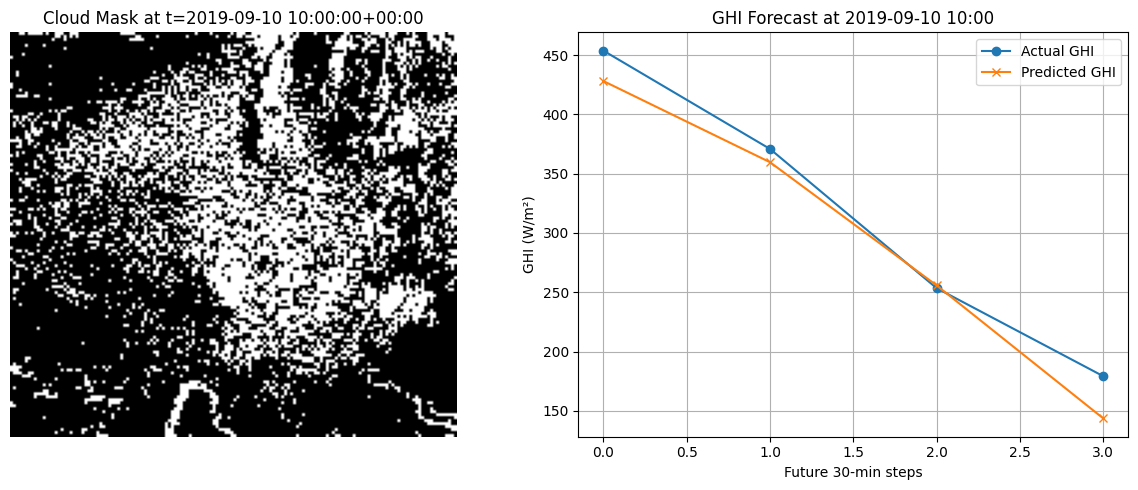

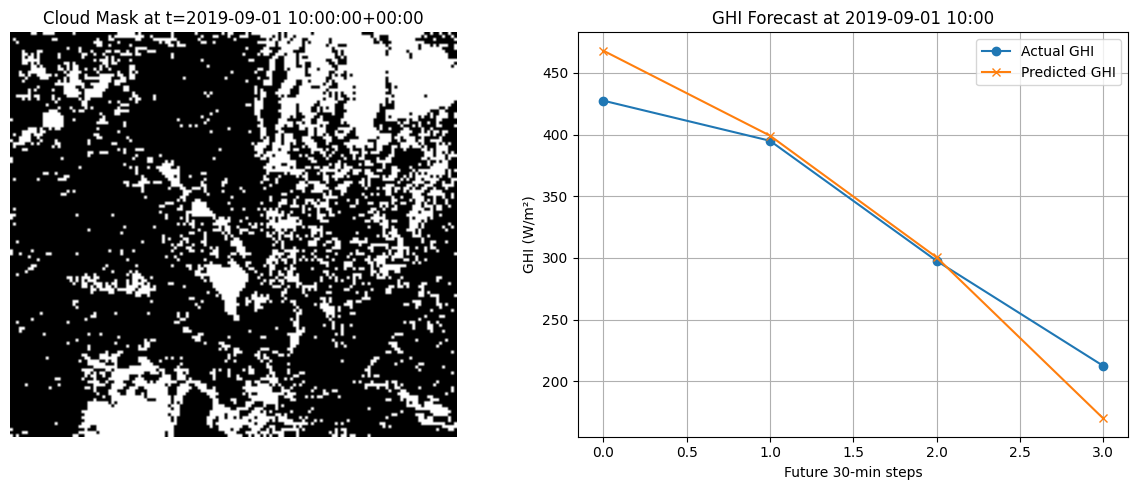

                  timestamp  forecasted_GHI
0 2019-09-01 11:00:00+05:30        0.480756
1 2019-09-01 11:30:00+05:30        0.462586
2 2019-09-01 12:00:00+05:30        0.448523
3 2019-09-01 12:30:00+05:30        0.525851
4 2019-09-01 13:00:00+05:30        0.590152


In [14]:
# ==== IMPORTS ====
import os
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from pvlib.location import Location
from tensorflow.keras import layers, models, callbacks, Input

# ==== RANDOM SEED ====
np.random.seed(42)
tf.random.set_seed(42)

# ==== LOCATION & TIME SETTINGS ====
altitude = 194
lat, lon = 13.627, 79.397
AOI = 'tirupati'
starttime = '2019-09-01 00:00:00'
endtime = '2019-09-30 23:59:00'

# ==== CLEAR-SKY ESTIMATION ====
date_range = pd.date_range(start=starttime, end=endtime, freq='1min')
location = Location(lat, lon, altitude=altitude, name=AOI)
clearsky = location.get_clearsky(date_range, model='simplified_solis')
clearsky.index = clearsky.index.tz_localize('UTC')
clear_ghi = clearsky['ghi'].values

# ==== LOAD CLOUD MASK MEANS ====
mask_dir = '/content/drive/MyDrive/PhD/cloud_masks'
mask_files = sorted([f for f in os.listdir(mask_dir) if f.endswith(".npy")])
file_timestamps, all_means, all_masks = [], [], []

for fname in mask_files:
    parts = fname.split('_')
    date_part, time_part = parts[2], parts[3].replace(".npy", "")
    ts = datetime.strptime(date_part + time_part, "%d%b%Y%H%M")
    timestamp = pd.to_datetime(ts).tz_localize('UTC')
    mask = np.load(os.path.join(mask_dir, fname))

    file_timestamps.append(timestamp)
    all_means.append(mask.mean())
    all_masks.append(mask)

cloud_mask_times = pd.to_datetime(file_timestamps)
cloud_mask_values = np.array(all_means)
cloud_masks = np.array(all_masks)

# ==== CLOUD INDEX ====
nmin = np.percentile(cloud_mask_values, 5)
nmax = np.percentile(cloud_mask_values, 95)
cloud_index = 1 - (cloud_mask_values - nmin) / (nmax - nmin)
cloud_index = np.clip(cloud_index, 0, 1)
cloud_index = pd.Series(cloud_index, index=cloud_mask_times)
cloud_index = cloud_index.rolling('15min').mean().bfill().values

# ==== ACTUAL GHI ====
actual_ghi = []
valid_indices = []

for i, ts in enumerate(cloud_mask_times):
    ts_rounded = ts.floor('min')
    if ts_rounded in clearsky.index:
        ghi_val = clearsky.loc[ts_rounded]['ghi']
        actual_ghi.append(ghi_val * cloud_index[i])
        valid_indices.append(i)
    else:
        actual_ghi.append(np.nan)

actual_ghi = np.array(actual_ghi)
valid_mask = ~np.isnan(actual_ghi)
actual_ghi = actual_ghi[valid_mask]
file_timestamps = np.array(file_timestamps)[valid_mask]
cloud_masks = cloud_masks[valid_mask]
cloud_index = cloud_index[valid_mask]
clear_ghi = clearsky.loc[file_timestamps]['ghi'].values

# ==== NORMALIZATION ====
scaler = MinMaxScaler()
ghi_reshaped = actual_ghi.reshape(-1, 1)
clear_reshaped = clear_ghi.reshape(-1, 1)
scaler.fit(np.concatenate([ghi_reshaped, clear_reshaped], axis=0))

ghi_norm = scaler.transform(ghi_reshaped).flatten()
clear_ghi_norm = scaler.transform(clear_reshaped).flatten()

# ==== FEATURES ====
hour = np.array([np.sin(2 * np.pi * ts.hour / 24) for ts in file_timestamps])
minute = np.array([np.sin(2 * np.pi * ts.minute / 60) for ts in file_timestamps])
features = np.stack([ghi_norm, clear_ghi_norm, hour, minute], axis=1)

# ==== SEQUENCE CREATION ====
seq_len, pred_len = 6, 4
X, y, time_y, masks_seq = [], [], [], []

for i in range(len(features) - seq_len - pred_len + 1):
    input_seq = features[i:i+seq_len]
    output_seq = ghi_norm[i+seq_len:i+seq_len+pred_len]

    if np.isnan(output_seq).any():
        continue

    X.append(input_seq)
    y.append(output_seq)
    time_y.append(file_timestamps[i+seq_len:i+seq_len+pred_len])
    masks_seq.append(cloud_masks[i+seq_len-1])

X = np.array(X, dtype='float32').reshape(-1, seq_len, 1, 1, 4)
y = np.array(y, dtype='float32')
time_y = np.array(time_y)
masks_seq = np.array(masks_seq, dtype='float32')

# ==== SPLIT ====
X_train, X_val, y_train, y_val, time_train, time_val, masks_train, masks_val = train_test_split(
    X, y, time_y, masks_seq, test_size=0.2, random_state=42
)

# ==== MODEL ====
model = models.Sequential([
    Input(shape=(seq_len, 1, 1, 4)),
    layers.ConvLSTM2D(64, (1, 1), activation='tanh', return_sequences=True),
    layers.BatchNormalization(),
    layers.ConvLSTM2D(64, (1, 1), activation='tanh', return_sequences=True),
    layers.BatchNormalization(),
    layers.ConvLSTM2D(32, (1, 1), activation='tanh', return_sequences=False),
    layers.BatchNormalization(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(pred_len)
])

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(optimizer=optimizer, loss='huber', metrics=['mae'])

# ==== CALLBACKS ====
early_stop = callbacks.EarlyStopping(patience=15, restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(patience=7, factor=0.3, verbose=1)
checkpoint = callbacks.ModelCheckpoint("best_model.h5", save_best_only=True, monitor="val_loss")

# ==== TRAIN ====
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=150,
    batch_size=32,
    callbacks=[early_stop, reduce_lr, checkpoint],
    verbose=1
)

# ==== PREDICT & INVERSE SCALE ====
y_pred = model.predict(X_val)
y_pred_denorm = scaler.inverse_transform(y_pred.reshape(-1, 1)).reshape(-1, pred_len)
y_val_denorm = scaler.inverse_transform(y_val.reshape(-1, 1)).reshape(-1, pred_len)

# ==== METRICS ====
flat_y_val = y_val_denorm.flatten()
flat_y_pred = y_pred_denorm.flatten()
mae = mean_absolute_error(flat_y_val, flat_y_pred)
rmse = np.sqrt(mean_squared_error(flat_y_val, flat_y_pred))
r2 = r2_score(flat_y_val, flat_y_pred)

print("\n\U0001F4CA Evaluation Metrics:")
print(f"MAE : {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²  : {r2:.2f}")

# ==== MOST ACCURATE GRAPHS ====
mse_per_sample = np.mean((y_val_denorm - y_pred_denorm)**2, axis=1)
top_indices = np.argsort(mse_per_sample)[:2]

for idx in top_indices:
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(masks_val[idx], cmap='gray')
    plt.title(f"Cloud Mask at t={time_val[idx][0]}")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.plot(range(pred_len), y_val_denorm[idx], label='Actual GHI', marker='o')
    plt.plot(range(pred_len), y_pred_denorm[idx], label='Predicted GHI', marker='x')
    plt.title(f"GHI Forecast at {time_val[idx][0].strftime('%Y-%m-%d %H:%M')}")
    plt.xlabel("Future 30-min steps")
    plt.ylabel("GHI (W/m²)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# ==== SAVE FORECAST ====
flat_time = time_val.flatten()
flat_pred = y_pred.flatten()
forecast_df = pd.DataFrame({
    'timestamp': flat_time,
    'forecasted_GHI': flat_pred
}).groupby('timestamp').mean().reset_index()

forecast_df['timestamp'] = pd.to_datetime(forecast_df['timestamp'], utc=True).dt.tz_convert('Asia/Kolkata')
print(forecast_df.head())


Epoch 1/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - loss: 0.2155 - mae: 0.5308

16/16 ━━━━━━━━━━━━━━━━━━━━ 21s 463ms/step - loss: 0.2121 - mae: 0.5257 - val_loss: 0.0699 - val_mae: 0.2915 - learning_rate: 0.0010
Epoch 2/150
13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0931 - mae: 0.3481

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0917 - mae: 0.3444 - val_loss: 0.0653 - val_mae: 0.2803 - learning_rate: 0.0010
Epoch 3/150
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0644 - mae: 0.2848

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0640 - mae: 0.2839 - val_loss: 0.0623 - val_mae: 0.2732 - learning_rate: 0.0010
Epoch 4/150
12/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0517 - mae: 0.2551

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0508 - mae: 0.2528 - val_loss: 0.0555 - val_mae: 0.2569 - learning_rate: 0.0010
Epoch 5/150
12/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0404 - mae: 0.2294

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0400 - mae: 0.2273 - val_loss: 0.0522 - val_mae: 0.2493 - learning_rate: 0.0010
Epoch 6/150
13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0341 - mae: 0.2103

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0340 - mae: 0.2099 - val_loss: 0.0485 - val_mae: 0.2405 - learning_rate: 0.0010
Epoch 7/150
13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0318 - mae: 0.1994

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0312 - mae: 0.1972 - val_loss: 0.0444 - val_mae: 0.2309 - learning_rate: 0.0010
Epoch 8/150
13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0291 - mae: 0.1924

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0288 - mae: 0.1910 - val_loss: 0.0418 - val_mae: 0.2254 - learning_rate: 0.0010
Epoch 9/150
13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0283 - mae: 0.1884

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0278 - mae: 0.1867 - val_loss: 0.0400 - val_mae: 0.2217 - learning_rate: 0.0010
Epoch 10/150
13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0243 - mae: 0.1767

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0244 - mae: 0.1765 - val_loss: 0.0369 - val_mae: 0.2156 - learning_rate: 0.0010
Epoch 11/150
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0223 - mae: 0.1655

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0224 - mae: 0.1657 - val_loss: 0.0338 - val_mae: 0.2094 - learning_rate: 0.0010
Epoch 12/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0221 - mae: 0.1659

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0221 - mae: 0.1658 - val_loss: 0.0334 - val_mae: 0.2090 - learning_rate: 0.0010
Epoch 13/150
12/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0220 - mae: 0.1647

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0219 - mae: 0.1645 - val_loss: 0.0320 - val_mae: 0.2068 - learning_rate: 0.0010
Epoch 14/150
11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0207 - mae: 0.1618

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0208 - mae: 0.1613 - val_loss: 0.0311 - val_mae: 0.2060 - learning_rate: 0.0010
Epoch 15/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0210 - mae: 0.1602 - val_loss: 0.0311 - val_mae: 0.2065 - learning_rate: 0.0010
Epoch 16/150
12/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0208 - mae: 0.1635

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0206 - mae: 0.1624 - val_loss: 0.0307 - val_mae: 0.2058 - learning_rate: 0.0010
Epoch 17/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0197 - mae: 0.1545 - val_loss: 0.0311 - val_mae: 0.2066 - learning_rate: 0.0010
Epoch 18/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0204 - mae: 0.1575 - val_loss: 0.0315 - val_mae: 0.2085 - learning_rate: 0.0010
Epoch 19/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0197 - mae: 0.1535 - val_loss: 0.0317 - val_mae: 0.2095 - learning_rate: 0.0010
Epoch 20/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0192 - mae: 0.1517 - val_loss: 0.0321 - val_mae: 0.2107 - learning_rate: 0.0010
Epoch 21/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0191 - mae: 0.1515 - val_loss: 0.0331 - val_mae: 0.2129 - learning_rate: 0.0010
Epoch 22/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0184 - mae: 0.1492 - val_loss: 0.0330 - val_mae: 0.2138 - learning_rate: 0.0010
Epoch 23/150

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0162 - mae: 0.1386 - val_loss: 0.0295 - val_mae: 0.1984 - learning_rate: 3.0000e-04
Epoch 30/150
12/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0170 - mae: 0.1441

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0169 - mae: 0.1434 - val_loss: 0.0274 - val_mae: 0.1916 - learning_rate: 3.0000e-04
Epoch 31/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0167 - mae: 0.1420

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0167 - mae: 0.1418 - val_loss: 0.0269 - val_mae: 0.1882 - learning_rate: 3.0000e-04
Epoch 32/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0164 - mae: 0.1386

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0164 - mae: 0.1385 - val_loss: 0.0265 - val_mae: 0.1843 - learning_rate: 3.0000e-04
Epoch 33/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0161 - mae: 0.1400

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0161 - mae: 0.1398 - val_loss: 0.0247 - val_mae: 0.1784 - learning_rate: 3.0000e-04
Epoch 34/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0170 - mae: 0.1426

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0170 - mae: 0.1424 - val_loss: 0.0228 - val_mae: 0.1722 - learning_rate: 3.0000e-04
Epoch 35/150
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0165 - mae: 0.1384

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0164 - mae: 0.1381 - val_loss: 0.0221 - val_mae: 0.1671 - learning_rate: 3.0000e-04
Epoch 36/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0160 - mae: 0.1370

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0160 - mae: 0.1368 - val_loss: 0.0216 - val_mae: 0.1654 - learning_rate: 3.0000e-04
Epoch 37/150
13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0160 - mae: 0.1390

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0159 - mae: 0.1382 - val_loss: 0.0207 - val_mae: 0.1631 - learning_rate: 3.0000e-04
Epoch 38/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0164 - mae: 0.1403

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0164 - mae: 0.1401 - val_loss: 0.0194 - val_mae: 0.1572 - learning_rate: 3.0000e-04
Epoch 39/150
13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0155 - mae: 0.1352

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0154 - mae: 0.1347 - val_loss: 0.0186 - val_mae: 0.1508 - learning_rate: 3.0000e-04
Epoch 40/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0152 - mae: 0.1333

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0152 - mae: 0.1332 - val_loss: 0.0185 - val_mae: 0.1532 - learning_rate: 3.0000e-04
Epoch 41/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0163 - mae: 0.1391

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0163 - mae: 0.1388 - val_loss: 0.0169 - val_mae: 0.1460 - learning_rate: 3.0000e-04
Epoch 42/150
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0158 - mae: 0.1367

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0158 - mae: 0.1367 - val_loss: 0.0162 - val_mae: 0.1407 - learning_rate: 3.0000e-04
Epoch 43/150
12/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0156 - mae: 0.1383

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0156 - mae: 0.1377 - val_loss: 0.0154 - val_mae: 0.1354 - learning_rate: 3.0000e-04
Epoch 44/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0155 - mae: 0.1363 - val_loss: 0.0168 - val_mae: 0.1403 - learning_rate: 3.0000e-04
Epoch 45/150
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0157 - mae: 0.1364

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0156 - mae: 0.1362 - val_loss: 0.0148 - val_mae: 0.1329 - learning_rate: 3.0000e-04
Epoch 46/150
12/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0159 - mae: 0.1384

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0158 - mae: 0.1377 - val_loss: 0.0146 - val_mae: 0.1319 - learning_rate: 3.0000e-04
Epoch 47/150
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0157 - mae: 0.1364

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0156 - mae: 0.1362 - val_loss: 0.0145 - val_mae: 0.1291 - learning_rate: 3.0000e-04
Epoch 48/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0148 - mae: 0.1335

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0148 - mae: 0.1335 - val_loss: 0.0143 - val_mae: 0.1288 - learning_rate: 3.0000e-04
Epoch 49/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0155 - mae: 0.1338 - val_loss: 0.0148 - val_mae: 0.1312 - learning_rate: 3.0000e-04
Epoch 50/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0156 - mae: 0.1347 - val_loss: 0.0148 - val_mae: 0.1303 - learning_rate: 3.0000e-04
Epoch 51/150
12/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0157 - mae: 0.1365

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0156 - mae: 0.1362 - val_loss: 0.0143 - val_mae: 0.1272 - learning_rate: 3.0000e-04
Epoch 52/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0151 - mae: 0.1345 - val_loss: 0.0145 - val_mae: 0.1297 - learning_rate: 3.0000e-04
Epoch 53/150
12/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0145 - mae: 0.1336

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0145 - mae: 0.1329 - val_loss: 0.0141 - val_mae: 0.1296 - learning_rate: 3.0000e-04
Epoch 54/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0154 - mae: 0.1337 - val_loss: 0.0150 - val_mae: 0.1316 - learning_rate: 3.0000e-04
Epoch 55/150
12/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0150 - mae: 0.1348

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0151 - mae: 0.1348 - val_loss: 0.0140 - val_mae: 0.1266 - learning_rate: 3.0000e-04
Epoch 56/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0149 - mae: 0.1337 - val_loss: 0.0144 - val_mae: 0.1282 - learning_rate: 3.0000e-04
Epoch 57/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0153 - mae: 0.1346 - val_loss: 0.0146 - val_mae: 0.1281 - learning_rate: 3.0000e-04
Epoch 58/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0150 - mae: 0.1318 - val_loss: 0.0143 - val_mae: 0.1268 - learning_rate: 3.0000e-04
Epoch 59/150
12/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0150 - mae: 0.1347

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0150 - mae: 0.1342 - val_loss: 0.0136 - val_mae: 0.1247 - learning_rate: 3.0000e-04
Epoch 60/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0155 - mae: 0.1345 - val_loss: 0.0144 - val_mae: 0.1284 - learning_rate: 3.0000e-04
Epoch 61/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0148 - mae: 0.1318 - val_loss: 0.0145 - val_mae: 0.1292 - learning_rate: 3.0000e-04
Epoch 62/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0151 - mae: 0.1328 - val_loss: 0.0138 - val_mae: 0.1244 - learning_rate: 3.0000e-04
Epoch 63/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0157 - mae: 0.1369 - val_loss: 0.0144 - val_mae: 0.1281 - learning_rate: 3.0000e-04
Epoch 64/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0153 - mae: 0.1329 - val_loss: 0.0141 - val_mae: 0.1289 - learning_rate: 3.0000e-04
Epoch 65/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0142 - mae: 0.1301 - val_loss: 0.0146 - val_mae: 0.1293 - learning_r

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0150 - mae: 0.1308 - val_loss: 0.0135 - val_mae: 0.1253 - learning_rate: 3.0000e-04
Epoch 67/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0143 - mae: 0.1307 - val_loss: 0.0137 - val_mae: 0.1242 - learning_rate: 9.0000e-05
Epoch 68/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0149 - mae: 0.1323 - val_loss: 0.0139 - val_mae: 0.1248 - learning_rate: 9.0000e-05
Epoch 69/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0141 - mae: 0.1284 - val_loss: 0.0137 - val_mae: 0.1226 - learning_rate: 9.0000e-05
Epoch 70/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0141 - mae: 0.1294 - val_loss: 0.0138 - val_mae: 0.1245 - learning_rate: 9.0000e-05
Epoch 71/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0142 - mae: 0.1306 - val_loss: 0.0136 - val_mae: 0.1229 - learning_rate: 9.0000e-05
Epoch 72/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0134 - mae: 0.1272 - val_loss: 0.0136 - val_mae: 0.1245 - learning_r

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0147 - mae: 0.1310 - val_loss: 0.0135 - val_mae: 0.1216 - learning_rate: 9.0000e-05
Epoch 74/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0142 - mae: 0.1312 - val_loss: 0.0136 - val_mae: 0.1235 - learning_rate: 9.0000e-05
Epoch 75/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0142 - mae: 0.1296 - val_loss: 0.0137 - val_mae: 0.1222 - learning_rate: 9.0000e-05
Epoch 76/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0149 - mae: 0.1323 - val_loss: 0.0138 - val_mae: 0.1273 - learning_rate: 9.0000e-05
Epoch 77/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0146 - mae: 0.1314 - val_loss: 0.0142 - val_mae: 0.1278 - learning_rate: 9.0000e-05
Epoch 78/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0138 - mae: 0.1271 - val_loss: 0.0135 - val_mae: 0.1229 - learning_rate: 9.0000e-05
Epoch 79/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0138 - mae: 0.1274 - val_loss: 0.0141 - val_mae: 0.1270 - learning_r

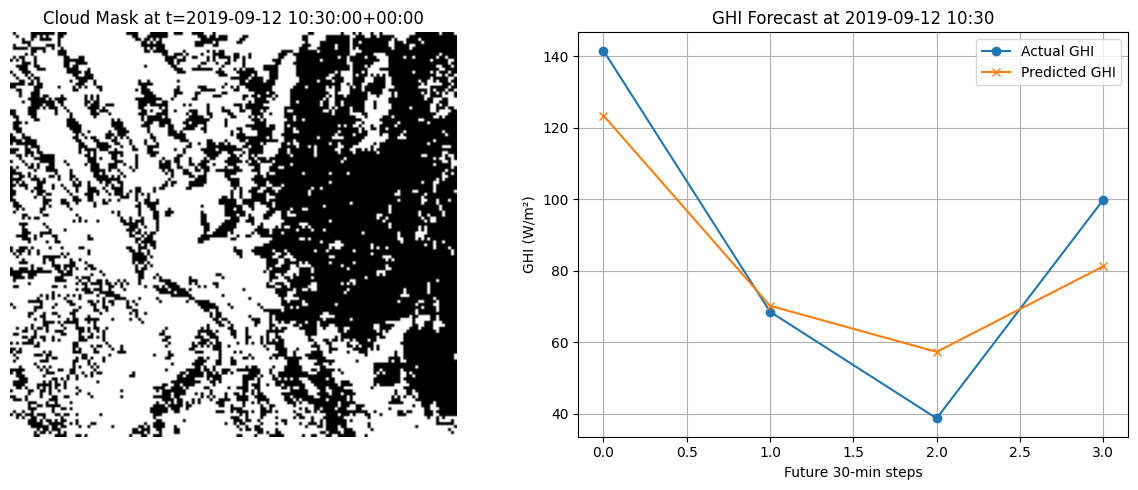

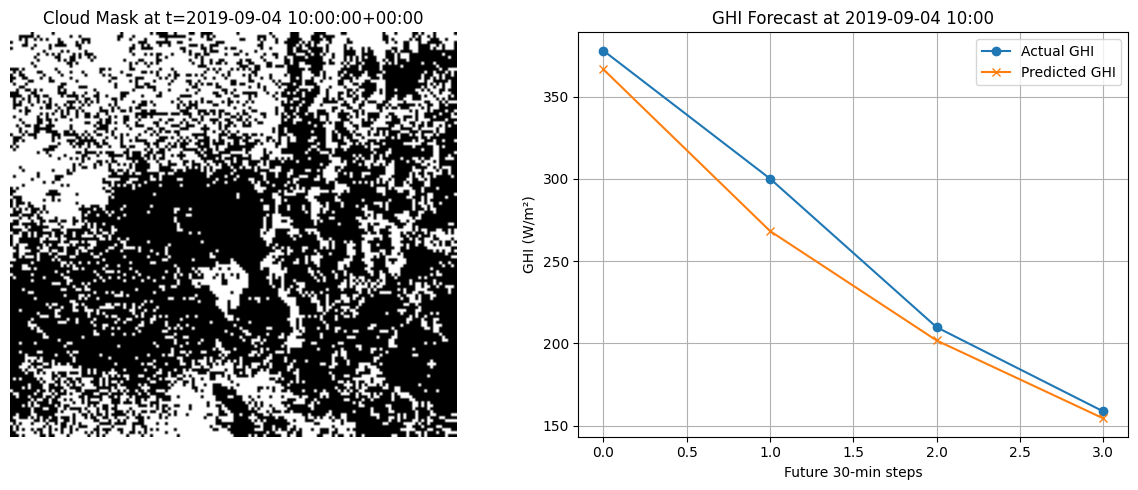

                  timestamp  forecasted_GHI
0 2019-09-01 11:00:00+05:30        0.602447
1 2019-09-01 11:30:00+05:30        0.512420
2 2019-09-01 12:00:00+05:30        0.434620
3 2019-09-01 12:30:00+05:30        0.512962
4 2019-09-01 13:00:00+05:30        0.630758


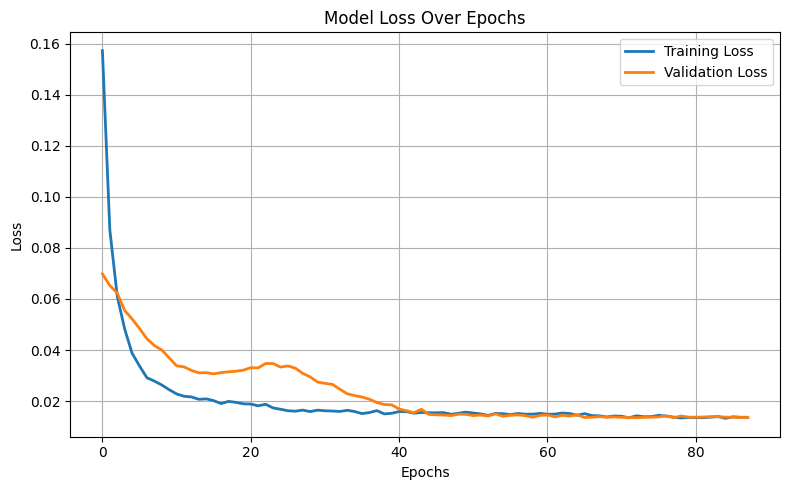

In [16]:
# ==== IMPORTS ====
import os
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from pvlib.location import Location
from tensorflow.keras import layers, models, callbacks, Input

# ==== RANDOM SEED ====
np.random.seed(42)
tf.random.set_seed(42)

# ==== LOCATION & TIME SETTINGS ====
altitude = 194
lat, lon = 13.627, 79.397
AOI = 'tirupati'
starttime = '2019-09-01 00:00:00'
endtime = '2019-09-30 23:59:00'

# ==== CLEAR-SKY ESTIMATION ====
date_range = pd.date_range(start=starttime, end=endtime, freq='1min')
location = Location(lat, lon, altitude=altitude, name=AOI)
clearsky = location.get_clearsky(date_range, model='simplified_solis')
clearsky.index = clearsky.index.tz_localize('UTC')
clear_ghi = clearsky['ghi'].values

# ==== LOAD CLOUD MASK MEANS ====
mask_dir = '/content/drive/MyDrive/PhD/cloud_masks'
mask_files = sorted([f for f in os.listdir(mask_dir) if f.endswith(".npy")])
file_timestamps, all_means, all_masks = [], [], []

for fname in mask_files:
    parts = fname.split('_')
    date_part, time_part = parts[2], parts[3].replace(".npy", "")
    ts = datetime.strptime(date_part + time_part, "%d%b%Y%H%M")
    timestamp = pd.to_datetime(ts).tz_localize('UTC')
    mask = np.load(os.path.join(mask_dir, fname))

    file_timestamps.append(timestamp)
    all_means.append(mask.mean())
    all_masks.append(mask)

cloud_mask_times = pd.to_datetime(file_timestamps)
cloud_mask_values = np.array(all_means)
cloud_masks = np.array(all_masks)

# ==== CLOUD INDEX ====
nmin = np.percentile(cloud_mask_values, 5)
nmax = np.percentile(cloud_mask_values, 95)
cloud_index = 1 - (cloud_mask_values - nmin) / (nmax - nmin)
cloud_index = np.clip(cloud_index, 0, 1)
cloud_index = pd.Series(cloud_index, index=cloud_mask_times)
cloud_index = cloud_index.rolling('15min').mean().bfill().values

# ==== ACTUAL GHI ====
actual_ghi = []
valid_indices = []

for i, ts in enumerate(cloud_mask_times):
    ts_rounded = ts.floor('min')
    if ts_rounded in clearsky.index:
        ghi_val = clearsky.loc[ts_rounded]['ghi']
        actual_ghi.append(ghi_val * cloud_index[i])
        valid_indices.append(i)
    else:
        actual_ghi.append(np.nan)

actual_ghi = np.array(actual_ghi)
valid_mask = ~np.isnan(actual_ghi)
actual_ghi = actual_ghi[valid_mask]
file_timestamps = np.array(file_timestamps)[valid_mask]
cloud_masks = cloud_masks[valid_mask]
cloud_index = cloud_index[valid_mask]
clear_ghi = clearsky.loc[file_timestamps]['ghi'].values

# ==== NORMALIZATION ====
scaler = MinMaxScaler()
ghi_reshaped = actual_ghi.reshape(-1, 1)
clear_reshaped = clear_ghi.reshape(-1, 1)
scaler.fit(np.concatenate([ghi_reshaped, clear_reshaped], axis=0))

ghi_norm = scaler.transform(ghi_reshaped).flatten()
clear_ghi_norm = scaler.transform(clear_reshaped).flatten()

# ==== FEATURES ====
hour = np.array([np.sin(2 * np.pi * ts.hour / 24) for ts in file_timestamps])
minute = np.array([np.sin(2 * np.pi * ts.minute / 60) for ts in file_timestamps])
features = np.stack([ghi_norm, clear_ghi_norm, hour, minute], axis=1)

# ==== SEQUENCE CREATION ====
seq_len, pred_len = 6, 4
X, y, time_y, masks_seq = [], [], [], []

for i in range(len(features) - seq_len - pred_len + 1):
    input_seq = features[i:i+seq_len]
    output_seq = ghi_norm[i+seq_len:i+seq_len+pred_len]

    if np.isnan(output_seq).any():
        continue

    X.append(input_seq)
    y.append(output_seq)
    time_y.append(file_timestamps[i+seq_len:i+seq_len+pred_len])
    masks_seq.append(cloud_masks[i+seq_len-1])

X = np.array(X, dtype='float32').reshape(-1, seq_len, 1, 1, 4)
y = np.array(y, dtype='float32')
time_y = np.array(time_y)
masks_seq = np.array(masks_seq, dtype='float32')

# ==== SPLIT ====
X_train, X_val, y_train, y_val, time_train, time_val, masks_train, masks_val = train_test_split(
    X, y, time_y, masks_seq, test_size=0.2, random_state=42
)

# ==== MODEL ====
model = models.Sequential([
    Input(shape=(seq_len, 1, 1, 4)),
    layers.ConvLSTM2D(64, (1, 1), activation='tanh', return_sequences=True),
    layers.BatchNormalization(),
    layers.ConvLSTM2D(64, (1, 1), activation='tanh', return_sequences=True),
    layers.BatchNormalization(),
    layers.ConvLSTM2D(32, (1, 1), activation='tanh', return_sequences=False),
    layers.BatchNormalization(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(pred_len)
])

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(optimizer=optimizer, loss='huber', metrics=['mae'])

# ==== CALLBACKS ====
early_stop = callbacks.EarlyStopping(patience=15, restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(patience=7, factor=0.3, verbose=1)
checkpoint = callbacks.ModelCheckpoint("best_model.h5", save_best_only=True, monitor="val_loss")

# ==== TRAIN ====
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=150,
    batch_size=32,
    callbacks=[early_stop, reduce_lr, checkpoint],
    verbose=1
)

# ==== PREDICT & INVERSE SCALE ====
y_pred = model.predict(X_val)
y_pred_denorm = scaler.inverse_transform(y_pred.reshape(-1, 1)).reshape(-1, pred_len)
y_val_denorm = scaler.inverse_transform(y_val.reshape(-1, 1)).reshape(-1, pred_len)

# ==== METRICS ====
flat_y_val = y_val_denorm.flatten()
flat_y_pred = y_pred_denorm.flatten()
mae = mean_absolute_error(flat_y_val, flat_y_pred)
rmse = np.sqrt(mean_squared_error(flat_y_val, flat_y_pred))
r2 = r2_score(flat_y_val, flat_y_pred)

print("\n\U0001F4CA Evaluation Metrics:")
print(f"MAE : {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²  : {r2:.2f}")

# ==== MOST ACCURATE GRAPHS ====
mse_per_sample = np.mean((y_val_denorm - y_pred_denorm)**2, axis=1)
top_indices = np.argsort(mse_per_sample)[:2]

for idx in top_indices:
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(masks_val[idx], cmap='gray')
    plt.title(f"Cloud Mask at t={time_val[idx][0]}")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.plot(range(pred_len), y_val_denorm[idx], label='Actual GHI', marker='o')
    plt.plot(range(pred_len), y_pred_denorm[idx], label='Predicted GHI', marker='x')
    plt.title(f"GHI Forecast at {time_val[idx][0].strftime('%Y-%m-%d %H:%M')}")
    plt.xlabel("Future 30-min steps")
    plt.ylabel("GHI (W/m²)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# ==== SAVE FORECAST ====
flat_time = time_val.flatten()
flat_pred = y_pred.flatten()
forecast_df = pd.DataFrame({
    'timestamp': flat_time,
    'forecasted_GHI': flat_pred
}).groupby('timestamp').mean().reset_index()

forecast_df['timestamp'] = pd.to_datetime(forecast_df['timestamp'], utc=True).dt.tz_convert('Asia/Kolkata')
print(forecast_df.head())

# ==== LOSS GRAPH ====
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

